# PyGreentea Network Generator 

### Load the dependencies

In [42]:
%matplotlib inline

from __future__ import print_function
import h5py
import numpy as np
from numpy import float32, int32, uint8, dtype
import sys
import matplotlib.pyplot as plt


pygt_path = '../PyGreentea'
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), pygt_path))

import math

import PyGreentea as pygt

### Set the memory limits for the GPU

In [56]:
# Load the default network template
netconf = pygt.netgen.NetConf()

# We use cuDNN, so:
netconf.ignore_conv_buffer = True

netconf.use_batchnorm = False
netconf.dropout = 0.0

# 4 GB total, ignore convolution buffer. Let's keep 0.5 GB for implementation dependent buffers.
netconf.mem_global_limit = 3.5 * 1024 * 1024 * 1024
# 4 GB convolution buffer limit
netconf.mem_buf_limit = 3.5 * 1024 * 1024 * 1024

# netconf.fmap_start = 20
# netconf.unet_fmap_inc_rule = lambda fmaps: int(math.ceil(fmaps * 1))
# netconf.unet_fmap_dec_rule = lambda fmaps: int(math.ceil(fmaps / 1))
# netconf.unet_depth = 3
# # netconf.unet_downsampling_strategy = [[3,3,3],[3,3,3],[1,1,1]]

netconf.fmap_start = 20
netconf.unet_fmap_inc_rule = lambda fmaps: int(math.ceil(fmaps * 1))
netconf.unet_fmap_dec_rule = lambda fmaps: int(math.ceil(fmaps / 1))
netconf.unet_depth = 4
netconf.unet_downsampling_strategy = [[2,2,2],[2,2,2],[1,1,1],[1,1,1]]

### Explore possible network input/output shapes for the chosen settings

In [57]:
# We test memory usage for training
mode = pygt.netgen.caffe_pb2.TRAIN
# The minimum we're interested in
shape_min = [100,100,100]
# And maximum
shape_max = [200,200,200]
# We want Z and Y to be independent, but X == Y
constraints = [None, None, lambda x: x[1]]
# Compute (can be quite intensive)
inshape, outshape, fmaps = pygt.netgen.compute_valid_io_shapes(netconf,mode,shape_min,shape_max,constraints=constraints)

-- Invalid: [100] => []
-- Invalid: [101] => []
-- Invalid: [102] => []
-- Invalid: [103] => []
-- Invalid: [104] => []
-- Invalid: [105] => []
-- Invalid: [106] => []
-- Invalid: [107] => []
++++ Valid: [108] => [4]
-- Invalid: [109] => []
-- Invalid: [110] => []
-- Invalid: [111] => []
++++ Valid: [112] => [8]
-- Invalid: [113] => []
-- Invalid: [114] => []
-- Invalid: [115] => []
++++ Valid: [116] => [12]
-- Invalid: [117] => []
-- Invalid: [118] => []
-- Invalid: [119] => []
++++ Valid: [120] => [16]
-- Invalid: [121] => []
-- Invalid: [122] => []
-- Invalid: [123] => []
++++ Valid: [124] => [20]
-- Invalid: [125] => []
-- Invalid: [126] => []
-- Invalid: [127] => []
++++ Valid: [128] => [24]
-- Invalid: [129] => []
-- Invalid: [130] => []
-- Invalid: [131] => []
++++ Valid: [132] => [28]
-- Invalid: [133] => []
-- Invalid: [134] => []
-- Invalid: [135] => []
++++ Valid: [136] => [32]
-- Invalid: [137] => []
-- Invalid: [138] => []
-- Invalid: [139] => []
++++ Valid: [140] => [36]


In [58]:
i=0
for o in zip(inshape,outshape,fmaps):
    print('i=' + str(i))
    print(o)
    i+=1

i=0
([108, 108, 108], [4, 4, 4], 166)
i=1
([112, 108, 108], [8, 4, 4], 160)
i=2
([116, 108, 108], [12, 4, 4], 154)
i=3
([120, 108, 108], [16, 4, 4], 149)
i=4
([124, 108, 108], [20, 4, 4], 144)
i=5
([128, 108, 108], [24, 4, 4], 139)
i=6
([132, 108, 108], [28, 4, 4], 135)
i=7
([136, 108, 108], [32, 4, 4], 131)
i=8
([140, 108, 108], [36, 4, 4], 127)
i=9
([144, 108, 108], [40, 4, 4], 123)
i=10
([148, 108, 108], [44, 4, 4], 120)
i=11
([152, 108, 108], [48, 4, 4], 116)
i=12
([156, 108, 108], [52, 4, 4], 113)
i=13
([160, 108, 108], [56, 4, 4], 110)
i=14
([164, 108, 108], [60, 4, 4], 108)
i=15
([168, 108, 108], [64, 4, 4], 105)
i=16
([172, 108, 108], [68, 4, 4], 102)
i=17
([176, 108, 108], [72, 4, 4], 100)
i=18
([180, 108, 108], [76, 4, 4], 98)
i=19
([184, 108, 108], [80, 4, 4], 96)
i=20
([188, 108, 108], [84, 4, 4], 93)
i=21
([192, 108, 108], [88, 4, 4], 91)
i=22
([196, 108, 108], [92, 4, 4], 90)
i=23
([200, 108, 108], [96, 4, 4], 88)
i=24
([108, 112, 112], [4, 8, 8], 154)
i=25
([112, 112, 11

### Visualization

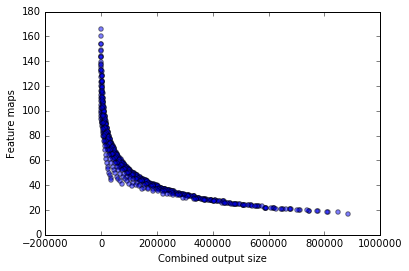

In [59]:
plt.figure()
# Combined output size versus feature map count
plt.scatter([x[0]*x[1]*x[2] for x in outshape], fmaps, alpha = 0.5)
plt.ylabel('Feature maps')
plt.xlabel('Combined output size')
plt.show()

### Pick parameters, actually generate and store the network

In [60]:
i=225
netconf.input_shape = inshape[i]
netconf.output_shape = outshape[i]
netconf.fmap_start = fmaps[i]

print ('netconf.input_shape = %s' % netconf.input_shape)
print ('netconf.output_shape = %s' % netconf.output_shape)
print ('netconf.fmap_start = %s' % netconf.fmap_start)

netconf.loss_function = "euclid"
train_net_conf_euclid, test_net_conf = pygt.netgen.create_nets(netconf)
netconf.loss_function = "malis"
train_net_conf_malis, test_net_conf = pygt.netgen.create_nets(netconf)

with open('net_train_euclid.prototxt', 'w') as f:
    print(train_net_conf_euclid, file=f)
with open('net_train_malis.prototxt', 'w') as f:
    print(train_net_conf_malis, file=f)
with open('net_test.prototxt', 'w') as f:
    print(test_net_conf, file=f)

netconf.input_shape = [144, 144, 144]
netconf.output_shape = [40, 40, 40]
netconf.fmap_start = 63
f: 1 w: [144, 144, 144] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
f: 63 w: [142, 142, 142] d: [1, 1, 1]
WM: 6804
CM: 322486272
AM: 0
f: 63 w: [140, 140, 140] d: [1, 1, 1]
WM: 428652
CM: 19481811552
AM: 0
f: 63 w: [70, 70, 70] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
f: 63 w: [68, 68, 68] d: [1, 1, 1]
WM: 428652
CM: 2333772000
AM: 0
f: 63 w: [66, 66, 66] d: [1, 1, 1]
WM: 428652
CM: 2139395328
AM: 0
f: 63 w: [33, 33, 33] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
f: 63 w: [31, 31, 31] d: [1, 1, 1]
WM: 428652
CM: 244515348
AM: 0
f: 63 w: [29, 29, 29] d: [1, 1, 1]
WM: 428652
CM: 202697964
AM: 0
f: 63 w: [29, 29, 29] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
f: 63 w: [27, 27, 27] d: [1, 1, 1]
WM: 428652
CM: 165942756
AM: 0
f: 63 w: [25, 25, 25] d: [1, 1, 1]
WM: 428652
CM: 133923132
AM: 0
f: 63 w: [25, 25, 25] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
f: 63 w: [23, 23, 23] d: [1, 1, 1]
WM: 428652
CM: 106312500
AM: 0
f: 63 w: [21, 21, 21] d: [1, 1, 1